# Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import h5py
import static_utils
import pathlib

%matplotlib inline

# Constants and Paths

In [2]:
# Main data paths for each catheter (manually input)
prepend = '/data/activeTracking-reorg1' # Change to empty string after zenodo get
parent_path = prepend + '/data/processed'
if (not os.path.isdir(parent_path)):
    print("Using precomputed outputs")
    parent_path = '../data/preprocessed'
main_path_222 = parent_path + '/static/trackTest-8Nov2021-C222-Y1/'
main_path_231 = parent_path + '/static/trackTest-21Dec2021-C231-Y1/'
main_path_306 = parent_path + '/static/trackTest-6Jan2022-C306-Y1/'

main_path = [main_path_222, main_path_231, main_path_306]

# Where you would like to save the heatmaps (manually input)
heatmap_path = '../reports/figures/static/Y20mm/'

# Tip error data is also exported to HDF5 files
error_path = '../reports/export/static/'

Gt_filename = '1GroundTruthCoords.csv'

geometry_index = 1

# Error Heatmaps for Y = 20 mm

For each sequence and localization algorithm of interest, plot the heatmap of average tip errors at each position. Each position has recordings from three catheters.

Tip Tracking Error @ Y = 20mm sequence SRI_Original, algorithm centroid_around_peak


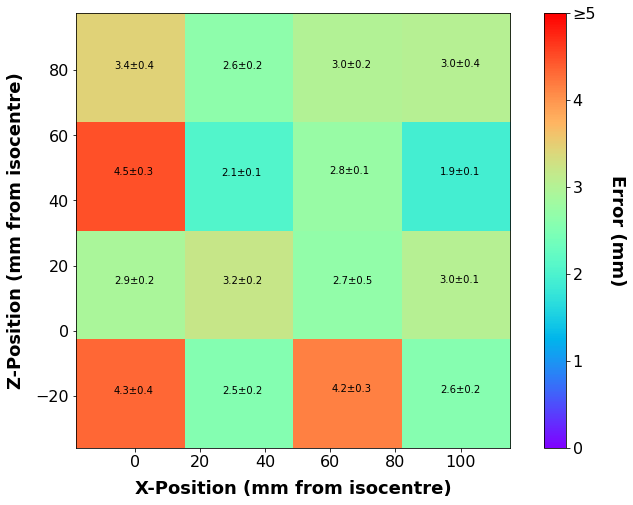

Saving error data from each catheter to: ../reports/export/static/Y1_SRI_Original_centroid_around_peak.h5
Tip Tracking Error @ Y = 20mm sequence SRI_Original, algorithm jpng


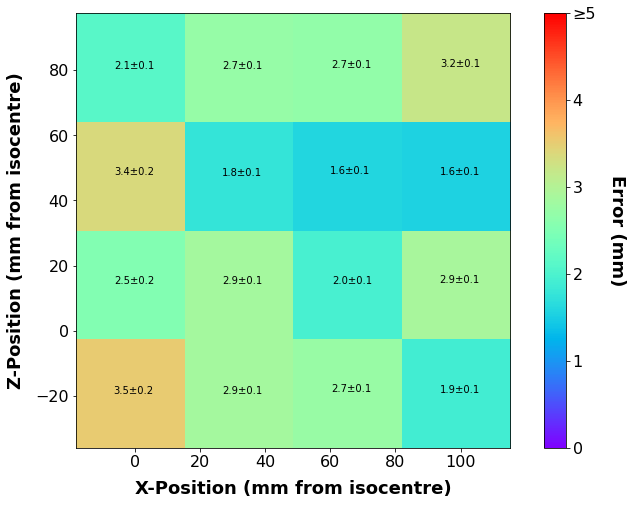

Saving error data from each catheter to: ../reports/export/static/Y1_SRI_Original_jpng.h5
Tip Tracking Error @ Y = 20mm sequence FH512_noDither_gradSpoiled, algorithm centroid_around_peak


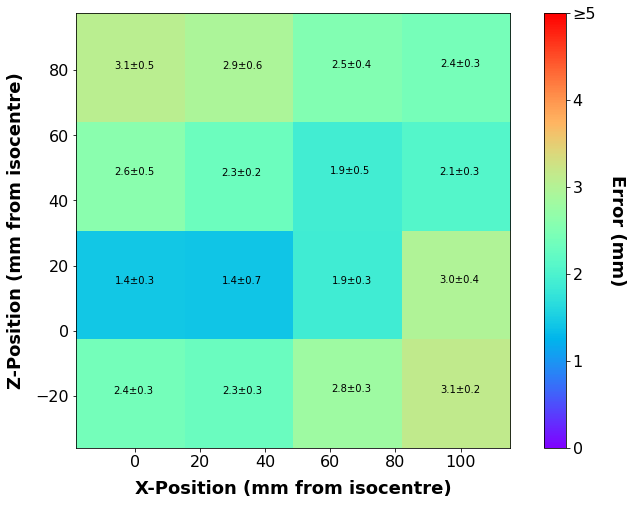

Saving error data from each catheter to: ../reports/export/static/Y1_FH512_noDither_gradSpoiled_centroid_around_peak.h5
Tip Tracking Error @ Y = 20mm sequence FH512_noDither_gradSpoiled, algorithm jpng


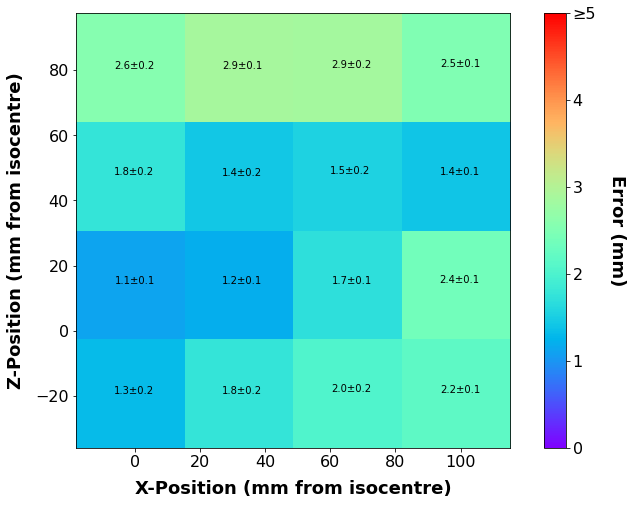

Saving error data from each catheter to: ../reports/export/static/Y1_FH512_noDither_gradSpoiled_jpng.h5


In [3]:
sequences = ['SRI_Original', 'FH512_noDither_gradSpoiled']
algorithms = ['centroid_around_peak', 'jpng']

os.makedirs(error_path, exist_ok=True)

for seq in sequences:
    for alg in algorithms:
        path_dct = static_utils.get_catheter_data(main_path, seq, alg, Gt_filename, geometry_index)
        # Average the error
        sum_all_caths = path_dct[main_path_222] + path_dct[main_path_231] + path_dct[main_path_306]
        avg_all_caths = sum_all_caths / 3
        avg_err = avg_all_caths[:, 2]
        stddev = np.sqrt(sum_all_caths[:, 3])

        my_data = np.array([avg_all_caths[:, 0], avg_all_caths[:, 1], avg_err]).T
        
        X = my_data[:, 0]
        Y = my_data[:, 1]
        Z = my_data[:, 2]

        heatmap = static_utils.nonuniform_imshow(X, Y, Z, stddev, numeric=True)
        plt.gca().invert_yaxis()
        plt.xlabel('X-Position (mm from isocentre)', fontsize = 18, fontweight = 'bold', labelpad = 10)
        plt.ylabel('Z-Position (mm from isocentre)', fontsize = 18, fontweight = 'bold', labelpad = 10)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        print('Tip Tracking Error @ Y = 20mm sequence {0}, algorithm {1}'.format(seq, alg))
        cbar = plt.colorbar(heatmap)
        cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '\u2265' + '5'])
        cbar.ax.get_yaxis().labelpad = 30
        cbar.ax.tick_params(labelsize = 16) 
        cbar.ax.set_ylabel('Error (mm)', rotation = 270, fontsize = 18, fontweight = 'bold')
        
        if not os.path.isdir('{0}'.format(heatmap_path)):
            os.makedirs('{0}'.format(heatmap_path))

        plt.savefig('{0}{1}_{2}_heatmap.png'.format(heatmap_path, seq, alg), dpi=300)
        plt.show()
        
        # Below we save the tip errors from each catheter to hdf5 format
        h5out = '{0}Y1_{1}_{2}.h5'.format(error_path, seq, alg)
        with h5py.File(h5out, 'w', libver='latest') as f:
            print("Saving error data from each catheter to: " + h5out)
            for k, v in path_dct.items():
                expmt = pathlib.PurePath(k).parts[-1]
                name = 'static_err_' + seq + '_' + alg + '_' + expmt
                f.create_dataset(name, data=v)

# HDF5 Exports
Error data has been saved to hdf5 (Hierarchical Data Format) files, one file for each sequence and algorithm combination. These can be read using your own code for further analysis, as shown in the code snippet below.

We check that we can open and read the most recent hdf5 file. The catheter error arrays are stored as datasets within this file.

Output the first dataset as an array from this file. This is a 2d array containing the tip errors for this catheter.

For each grid position:
the ground truth X coordinate, Z coordinate, bias (tip error) in mm, tip variance in mm (in that order)

So, there are 16 elements arranged like:

`[ [GT_x_pos0, GT_z_pos0, bias_pos0, variance_pos0], [GT_x_pos1, GT_z_pos1, bias_pos1, variance_pos1], ... [GT_x_pos15, GT_z_pos15, bias_pos15, variance_pos2] ]`

In [4]:
with h5py.File(h5out, 'r', libver='latest') as f:
    first_dataset = list(f.keys())[0]

    print("Looking at catheter tip errors for " + first_dataset \
          + "\n from the file: " + h5out)
    
    # Can also use h5py dataset object: ds_obj = f[a_group_key]
    # The 2d array contains the tip error for this catheter
    ds_arr = f[first_dataset][()]  # returns as a numpy array
    print(ds_arr)

Looking at catheter tip errors for static_err_FH512_noDither_gradSpoiled_jpng_trackTest-21Dec2021-C231-Y1
 from the file: ../reports/export/static/Y1_FH512_noDither_gradSpoiled_jpng.h5
[[-1.71154194e+00 -1.88694093e+01  2.06192212e+00  2.08137295e-02]
 [ 3.15289496e+01 -1.84819449e+01  1.97532510e+00  1.07190166e-02]
 [ 6.36873849e+01 -1.77868784e+01  3.17482981e+00  5.15611322e-03]
 [ 9.75616320e+01 -1.76959927e+01  2.22424286e+00  4.46089111e-03]
 [ 9.72299969e+01  1.49966231e+01  2.45499607e+00  4.96867079e-03]
 [ 6.44971669e+01  1.49059791e+01  1.88432383e+00  4.15744255e-03]
 [ 3.10930824e+01  1.44786042e+01  1.68291147e+00  4.08280285e-03]
 [-2.11070051e+00  1.44690975e+01  9.04831286e-01  5.80330610e-03]
 [-2.31135816e+00  4.83541123e+01  2.03356089e+00  7.24965490e-03]
 [ 3.02676537e+01  4.77055868e+01  1.05975957e+00  7.52540066e-03]
 [ 6.34374252e+01  4.85879018e+01  2.35483374e+00  1.21798457e-02]
 [ 9.76803093e+01  4.87978722e+01  1.16029138e+00  9.16458151e-03]
 [ 9.754155